In [161]:
import numpy as np
import matplotlib.pyplot as plt
# to save and write as pngs
from imageio import imwrite, imread
import scipy.ndimage
import scipy.sparse.csgraph
import math
import SimpleITK as sitk
import sklearn.cluster
import sklearn.preprocessing

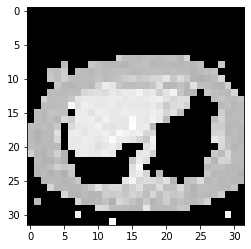

In [63]:
# get image
image_dcm = sitk.ReadImage('data/IMG-0002-00074.dcm');
image_array_view = sitk.GetArrayViewFromImage(image_dcm)
image = image_array_view.squeeze()

# scale down image
scaling_factor = 16
image = scipy.ndimage.affine_transform(image, matrix=[[scaling_factor, 0], [0, scaling_factor]], offset=0, output_shape=(int(image.shape[0]/scaling_factor), int(image.shape[1]/scaling_factor)))

# clip values to range -160 <-> 240, which is the intensity values of blood-filled organs.
image[image < -160] = -1024
image[image > 240] = -1024

image = np.sqrt((image+np.abs(np.min(image)))**2) # add an offset and 'remove' negative values
image = image/np.max(image) # normalize

# plot image
plt.imshow(image, cmap='gray');

In [220]:
# similarity matrix - nodes are connected if they are neighbours and they share the same value
num_pixels = image.size

similarity_matrix = np.zeros((num_pixels,num_pixels),dtype=float)

image_width = image.shape[0]

max_distance = 5

sigma_distance = int(0.1 * image_width) # 10-20% of feature distance
sigma_intensity = 102 # 10-20% of feature distance (-1024 <-> 1024)

for i in range(0,image_width):
    for j in range(0,image_width):
        sm_i = j + i * image_width
        for ii in range(0,image_width):
            for jj in range(0,image_width):
                sm_j = jj + ii * image_width

                distance = np.linalg.norm(np.array([i,j]) - np.array([ii,jj]))

                if distance > max_distance:
                    similarity_matrix[sm_i,sm_j] = 0
                else:
                    intensity_diff = np.linalg.norm(np.array(image[i,j]) - np.array(image[ii,jj]))
                    weight = np.exp(-np.power(intensity_diff,2)/sigma_intensity) * np.exp(-np.power(distance,2)/sigma_distance)
                    similarity_matrix[sm_i,sm_j] = weight


In [221]:

# debug purposes
np.savetxt("similarity.csv", similarity_matrix, fmt='%i', delimiter=",")
print(similarity_matrix)

[[1.         0.71653131 0.26359714 ... 0.         0.         0.        ]
 [0.71653131 1.         0.71653131 ... 0.         0.         0.        ]
 [0.26359714 0.71653131 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.71653131 0.26359714]
 [0.         0.         0.         ... 0.71653131 1.         0.71653131]
 [0.         0.         0.         ... 0.26359714 0.71653131 1.        ]]


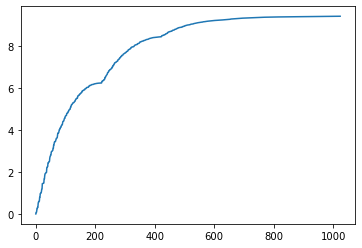

In [259]:
# clustering following: https://changyaochen.github.io/spectral-clustering/
graph_laplacian = scipy.sparse.csgraph.laplacian(similarity_matrix,normed=True)

# get eigenvalues + vectors
eigenvalues, eigenvectors = np.linalg.eigh(graph_laplacian)

ind = np.argsort(eigenvalues, axis=0)

eigenvalues = eigenvalues[ind]
eigenvectors = eigenvectors[:,ind]

plt.plot(eigenvalues)

(1024, 1024)
(1024, 3)


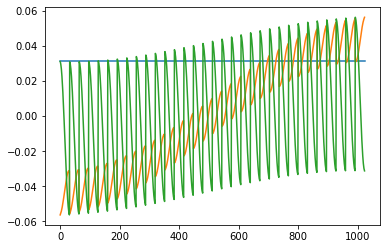

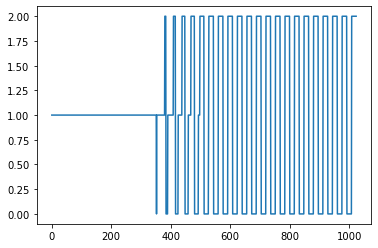

In [262]:
n_clusters = 3

print(eigenvectors.shape)
selected_eigenvectors = eigenvectors[:,:n_clusters]

#selected_eigenvectors = sklearn.preprocessing.normalize(selected_eigenvectors, norm='l2', axis=1)

# k-means
clusters = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(selected_eigenvectors)

print(selected_eigenvectors.shape)
plt.plot(selected_eigenvectors)
plt.show()
plt.plot(clusters.labels_)

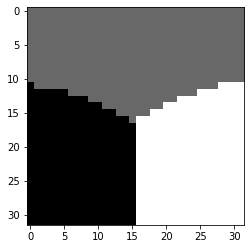

In [263]:
# cluster => image

colors = [-1024,-900,-720,-500,-250,0,250,500,720,900,1024]

cluster_image = np.zeros(image.shape)

for i, l in enumerate(clusters.labels_):
    x = i % image_width
    y = int(i / image_width)
    cluster_image[y,x] = colors[l]

# plot image
plt.imshow(cluster_image, cmap='gray');